# Project 2: Clustering

## Imports

In [99]:
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.decomposition import TruncatedSVD, NMF
from scipy.sparse.linalg import svds
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, scale

import matplotlib.pyplot as plt
import numpy as np
import nltk, re
import pickle

## Datasets

In [100]:
categories = ['comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware',
                  'rec.autos', 'rec.motorcycles', 'rec.sport.baseball', 'rec.sport.hockey']

twenty_dataset = fetch_20newsgroups(subset='all', categories = categories, shuffle = True, random_state =  42,remove=('headers','footers','quotes'))
twenty_all = fetch_20newsgroups(subset='all', categories = None, shuffle = True, random_state =  42)

## Part 1:  Building the TF-IDF Matrix

In [101]:
## Part 1: Building the TF-IDF Matrix

def tfidf(dataset):
    vectorizer = TfidfVectorizer(min_df=3, stop_words='english')
    tfidf = vectorizer.fit_transform(dataset.data)
    print('Dimensions of TF-IDF matrix: ' + str(tfidf.shape))
    return tfidf

tfidf_data = tfidf(twenty_dataset)

Dimensions of TF-IDF matrix: (7882, 18469)


## Part 2: Applying K-means with k=2 to the TF-IDF data

In [102]:
## Part 2: Applying K-means with k=2 to the TF-IDF data

def calc_contigency_matrix(original, k_predicted):
    print ("Contingency Matrix: \n", metrics.confusion_matrix(original, k_predicted))

def calc_metrics(original, k_predicted):
    print("Homogeneity score: %0.3f" % metrics.homogeneity_score(original, k_predicted))
    print("Completeness score: %0.3f" % metrics.completeness_score(original, k_predicted))
    print("V_measure : %0.3f" % metrics.v_measure_score(original, k_predicted))
    print("Adjusted Rand-Index: %.3f" % metrics.adjusted_rand_score(original,k_predicted))
    print("Adjusted Mutual info score: %.3f" % metrics.adjusted_mutual_info_score(original, k_predicted))

In [103]:
def kmeans_clustering(nclusters, tfidf_data, label):
    k_cluster= KMeans(n_clusters=nclusters, init='k-means++', max_iter=100, n_init=1)
    k_predicted=k_cluster.fit(tfidf_data)
    labels= label

    calc_contigency_matrix(labels, k_cluster.labels_)
    calc_metrics(labels, k_cluster.labels_)

labels= [ int(x / 4) for x in twenty_dataset.target]
kmeans_clustering(2, tfidf_data, labels)

Contingency Matrix: 
 [[2588 1315]
 [  46 3933]]
Homogeneity score: 0.417
Completeness score: 0.453
V_measure : 0.434
Adjusted Rand-Index: 0.429
Adjusted Mutual info score: 0.417


## Part 3a (i): Dimensionality Reduction using LSI and NMF

In [104]:
## Part 3a (i): Dimensionality Reduction using LSI and NMF

def save_scores(actual_labels, predicted_labels, h, c , v ,r , m):
    h.append(metrics.homogeneity_score(actual_labels, predicted_labels))
    c.append(metrics.completeness_score(actual_labels, predicted_labels))
    v.append(metrics.v_measure_score(actual_labels, predicted_labels))
    r.append(metrics.adjusted_rand_score(actual_labels, predicted_labels))
    m.append(metrics.adjusted_mutual_info_score(actual_labels, predicted_labels))
    return h, c, v, r, m

In [106]:
num_of_singular_values = 1000
u, singular_values, vt = svds(tfidf_data.toarray(), num_of_singular_values)
singular_values = singular_values[::-1]
print('Top',num_of_singular_values,'singular values are:')
print(singular_values)

with open("singular_values.pkl","wb") as f:
    s = pickle.dump(singular_values,f)

In [108]:
with open("singular_values.pkl","rb") as f:
    s = pickle.load(f) 

ratio = []
total_var = 0
for i in s:
    total_var += i**2

ratio = []
ratio.append((s[0]**2)/total_var)
sum_r = s[0]**2
for i in range(2, 1001):
    ratio.append((sum_r + s[i-1]**2)/total_var)
    sum_r += s[i-1]**2

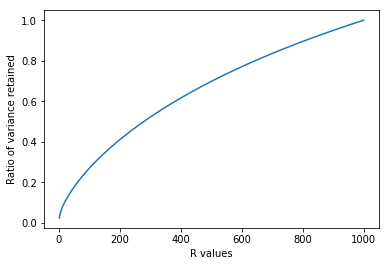

In [109]:
r = [i for i in range(1, 1001)]

plt.plot(r, ratio)
plt.xlabel('R values')
plt.ylabel('Ratio of variance retained')
plt.show()

## Part 3a(ii): Finding the best dimension parameter r

R:  1
[[2213 1690]
 [1123 2856]]
R:  2
[[2619 1284]
 [  59 3920]]
R:  3
[[1314 2589]
 [3922   57]]
R:  5
[[1452 2451]
 [3954   25]]
R:  10
[[1312 2591]
 [3935   44]]
R:  20
[[1322 2581]
 [3940   39]]
R:  30
[[1333 2570]
 [3947   32]]
R:  50
[[2556 1347]
 [  34 3945]]
R:  100
[[2534 1369]
 [  33 3946]]
R:  300
[[1363 2540]
 [3948   31]]


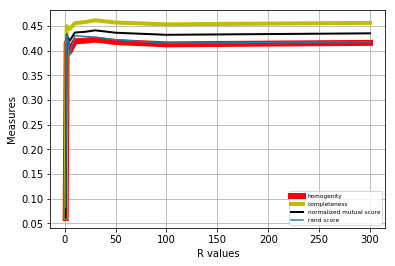


h:  [0.060815390048006499, 0.41588817192852934, 0.40966701992395554, 0.39863799771652636, 0.41890279688637821, 0.4199320251624763, 0.42232051928609182, 0.41734516383918657, 0.41265240100449424, 0.41562720495905581]

c:  [0.061867208567740334, 0.44977790735131151, 0.44494798542304842, 0.44394350649584724, 0.45566240406306685, 0.45772941551299851, 0.46149722854960412, 0.45684009909325157, 0.45320948725933324, 0.45621008748035963]

v:  [0.061336790428003989, 0.43216966943602975, 0.42657925280732817, 0.42007271615625696, 0.43651006303650897, 0.43801682864152125, 0.44104058712881472, 0.43620045793226458, 0.43198109446894922, 0.43497410624188126]

r:  [0.081807139568020396, 0.43450590698852676, 0.42518804075614225, 0.3908281452279001, 0.43016728784639857, 0.4285043802835149, 0.4271763930513478, 0.42188485176182439, 0.41498976445604313, 0.41760978366146151]

m:  [0.060729406908589814, 0.4158346947735298, 0.40961297311380784, 0.39858294061573807, 0.4188495956088289, 0.41987891807070277, 0.422

In [114]:
## Part 3a(ii): Finding the best dimension parameter r - best r=30

## SVD 

def calc_scores_for_svd(tfidf_data, l, label, nclusters):
    h = []
    c = []
    v = []
    r = []
    m = []
    ks = []
    
    for n in l:
        print("R: ", n)
        svd = TruncatedSVD(n_components=n)
        X_svd = svd.fit_transform(tfidf_data)

        labels= label
        kmeans = KMeans(n_clusters=nclusters).fit(X_svd)

        print(metrics.confusion_matrix(labels, kmeans.labels_))
        h, c, v, r, m = save_scores(labels, kmeans.labels_, h, c , v ,r , m)
        ks.append(n)

    plt.plot(ks, h, 'r', lw=6, label='homogenity')
    plt.plot(ks, c, 'y', lw=4, label='completeness')
    plt.plot(ks, v, 'k', lw=2, label='normalized mutual score')
    plt.plot(ks, r, label='rand score')
    plt.grid()
    plt.xlabel('R values')
    plt.ylabel('Measures')
    plt.legend(fontsize='xx-small')
    plt.show()
    
    print("\nh: ", h)
    print("\nc: ", c)
    print("\nv: ", v)
    print("\nr: ", r)
    print("\nm: ", m)

labels = [ int(x / 4) for x in twenty_dataset.target]
r = [1, 2, 3, 5, 10, 20, 30, 50, 100, 300]
calc_scores_for_svd(tfidf_data, r, labels, 2)

R:  1
[[1690 2213]
 [2856 1123]]
R:  2
[[3633  270]
 [ 788 3191]]
R:  3
[[3517  386]
 [3962   17]]
R:  5
[[2486 1417]
 [ 110 3869]]
R:  10
[[   4 3899]
 [1233 2746]]
R:  20
[[2844 1059]
 [ 121 3858]]
R:  30
[[   8 3895]
 [1114 2865]]
R:  50
[[ 277 3626]
 [ 109 3870]]
R:  100
[[   0 3903]
 [  20 3959]]
R:  300
[[3816   87]
 [3919   60]]


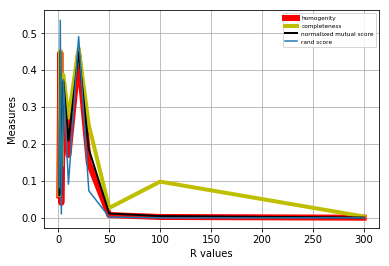


h:  [0.060815390048006499, 0.44717190609737173, 0.040593827540793721, 0.35415499164683206, 0.17035731909746474, 0.43853876013181825, 0.1480136188232988, 0.007581307417145907, 0.0025070338997013131, 0.00051493762885001626]

c:  [0.061867208567740334, 0.45199058291946975, 0.13940483431334139, 0.38733806889581135, 0.27171081663207342, 0.45903047171799605, 0.25070098784044104, 0.026880798113522789, 0.098174322120314225, 0.0038485173507931043]

v:  [0.061336790428003989, 0.44956833268958962, 0.062877976360230362, 0.37000403066188103, 0.20941534822379637, 0.44855070068537423, 0.18613394058138547, 0.01182699611522533, 0.0048892141179920955, 0.00090833819001273663]

r:  [0.081807139568020396, 0.53509233922553578, 0.010566870787302477, 0.37512217678006504, 0.091228613549751675, 0.49075384006930306, 0.073337990911277851, 0.0026332301020447744, -7.2461599701357783e-05, 0.00017659052266105185]

m:  [0.060729406908589814, 0.44712129433799758, 0.040505900735849566, 0.35409586237684787, 0.1702813479

In [154]:
## NMF - best r=2

def calc_scores_for_nmf(data_idf, l, label, nclusters):

    h = []
    c = []
    v = []
    r = []
    m = []
    ks = []

    for n in l:
        print("R: ", n)
        nmf = NMF(n_components=n)
        X_nmf = nmf.fit_transform(data_idf)
        
        labels = label
        kmeans = KMeans(n_clusters=nclusters).fit(X_nmf)

        print(metrics.confusion_matrix(labels, kmeans.labels_))
        h, c, v, r, m = save_scores(labels, kmeans.labels_, h, c , v ,r, m)
        ks.append(n)

    plt.plot(ks, h, 'r', lw=6, label='homogenity')
    plt.plot(ks, c, 'y', lw=4, label='completeness')
    plt.plot(ks, v, 'k', lw=2, label='normalized mutual score')
    plt.plot(ks, r, label='rand score')
    plt.grid()
    plt.xlabel('R values')
    plt.ylabel('Measures')
    plt.legend(fontsize='xx-small')
    plt.show()
    
    print("\nh: ", h)
    print("\nc: ", c)
    print("\nv: ", v)
    print("\nr: ", r)
    print("\nm: ", m)

labels = [ int(x / 4) for x in twenty_dataset.target]
r = [1, 2, 3, 5, 10, 20, 30, 50, 100, 300]
calc_scores_for_nmf(tfidf_data, r, labels, 2)

## Part 4a: Visualizing the performance of case with best clustering results.

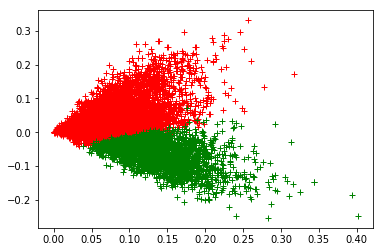

In [115]:
## Part 4a: Visualizing the performance of case with best clustering results. r=30 for svd and r= for nmf

# SVD

def visualize_svd(data_idf, nclusters, ncomponents):
    svd = TruncatedSVD(n_components=ncomponents)
    X_svd = svd.fit_transform(data_idf)

    kmeans = KMeans(n_clusters=nclusters).fit(X_svd)
    
    svd2 = TruncatedSVD(n_components=2)
    X_svd2 = svd2.fit_transform(X_svd)
    
    x1 = X_svd2[kmeans.labels_==0][:, 0]
    y1 = X_svd2[kmeans.labels_==0][:, 1]
    
    plt.plot(x1, y1, 'r+')
    
    x2 = X_svd2[kmeans.labels_==1][:, 0]
    y2 = X_svd2[kmeans.labels_==1][:, 1]
    
    plt.plot(x2, y2, 'g+')
    plt.show()
    
visualize_svd(tfidf_data, 2, 30)

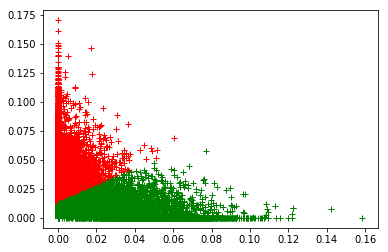

In [116]:
# NMF r=2

def visualize_nmf(data_idf, nclusters, ncomponents):
    nmf = NMF(n_components=ncomponents)
    X_nmf = nmf.fit_transform(data_idf)

    kmeans = KMeans(n_clusters=nclusters).fit(X_nmf)
    
#     nmf2 = TruncatedSVD(n_components=2)
#     X_nmf2 = nmf2.fit_transform(X_nmf)
    
    x1 = X_nmf[kmeans.labels_==0][:, 0]
    y1 = X_nmf[kmeans.labels_==0][:, 1]
    #print(len(X_nmf[kmeans.labels_==0][0]))
    
    plt.plot(x1, y1, 'r+')
    
    x2 = X_nmf[kmeans.labels_==1][:, 0]
    y2 = X_nmf[kmeans.labels_==1][:, 1]
    
    plt.plot(x2, y2, 'g+')
    plt.show()
    
visualize_nmf(tfidf_data, 2, 2)

## Part 4b(i): Visualizing the transformed data after normalizing 

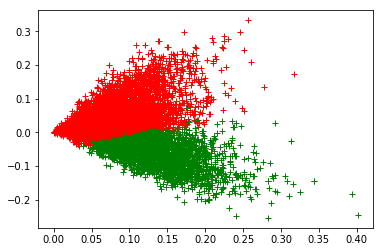

Contigency matrix: 
 [[1359 2544]
 [3946   33]]

h:  [0.41511671365489067]

c:  [0.45525253806387006]

v:  [0.4342592229928342]

r:  [0.41826605899950109]

m:  [0.41506316557643408]


In [155]:
## Part 4b(i): Visualizing the transformed data after normalizing 

# SVD

def visualize_svd_normalized(data_idf, label, ncomponents, nclusters):
    h = []
    c = []
    v = []
    r = []
    m = []
    ks = []
    
    svd = TruncatedSVD(n_components=ncomponents)
    scaler = StandardScaler(copy=False)
    pipeline = make_pipeline(svd, scaler)
    X_svd = svd.fit_transform(data_idf)

    labels= label  
    kmeans = KMeans(n_clusters=nclusters).fit(X_svd)
    
    svd2 = TruncatedSVD(n_components=2)
    X_svd2 = svd2.fit_transform(X_svd)
    
    #print(len(X_svd2[kmeans.labels_==0][0]))
    
    x1 = X_svd2[kmeans.labels_==0][:, 0]
    y1 = X_svd2[kmeans.labels_==0][:, 1]
    
    plt.plot(x1, y1, 'r+')
    
    x2 = X_svd2[kmeans.labels_==1][:, 0]
    y2 = X_svd2[kmeans.labels_==1][:, 1]
    
    plt.plot(x2, y2, 'g+')
    plt.show()
    
    print("Contigency matrix: \n", metrics.confusion_matrix(labels, kmeans.labels_))
    h, c, v, r, m = save_scores(labels, kmeans.labels_, h, c , v ,r , m)
    
    print("\nh: ", h)
    print("\nc: ", c)
    print("\nv: ", v)
    print("\nr: ", r)
    print("\nm: ", m)

labels = [ int(x / 4) for x in twenty_dataset.target]
visualize_svd_normalized(tfidf_data, labels, 30, 2)

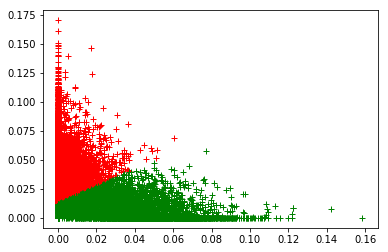

Contigency matrix: 
 [[ 300 3603]
 [3269  710]]

h:  [0.45837858761389916]

c:  [0.46131721334117681]

v:  [0.45984320570718235]

r:  [0.5530626716804482]

m:  [0.45832900190967441]


In [118]:
# NMF

def visualize_nmf_normalized(data_idf, label, ncomponents, nclusters):
    h = []
    c = []
    v = []
    r = []
    m = []
    ks = []
    
    nmf = NMF(n_components=ncomponents)
    scaler = StandardScaler(copy=False)
    pipeline = make_pipeline(nmf, scaler)
    X_svd = nmf.fit_transform(data_idf)

    labels = label
    kmeans = KMeans(n_clusters=nclusters).fit(X_svd)
    
#     svd2 = TruncatedSVD(n_components=2)
#     X_svd2 = svd2.fit_transform(X_svd)
    
    x1 = X_svd[kmeans.labels_==0][:, 0]
    y1 = X_svd[kmeans.labels_==0][:, 1]
    
    plt.plot(x1, y1, 'r+')
    
    x2 = X_svd[kmeans.labels_==1][:, 0]
    y2 = X_svd[kmeans.labels_==1][:, 1]
    
    plt.plot(x2, y2, 'g+')
    plt.show()
    
    print("Contigency matrix: \n", metrics.confusion_matrix(labels, kmeans.labels_))
    h, c, v, r, m = save_scores(labels, kmeans.labels_, h, c , v ,r , m)
    
    print("\nh: ", h)
    print("\nc: ", c)
    print("\nv: ", v)
    print("\nr: ", r)
    print("\nm: ", m)

labels = [ int(x / 4) for x in twenty_dataset.target]
visualize_nmf_normalized(tfidf_data, labels, 2, 2)

## Part 4b(ii): Visualizing the transformed data after a non-linear (logarithm) transformation (NMF)

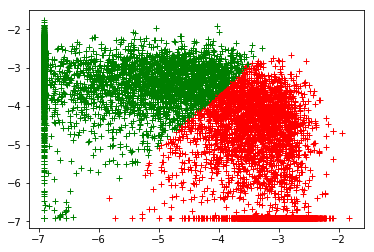

Contigency matrix: 
 [[3422  481]
 [ 302 3677]]

h:  [0.53549672000289172]

c:  [0.53663502705530663]

v:  [0.53606526924564746]

r:  [0.64206750415703473]

m:  [0.53545419456551313]


In [119]:
## Part 4b(ii): Visualizing the transformed data after a non-linear (logarithm) transformation (NMF)


def visualize_nmf_log(data_idf, label, ncomponents, nclusters):
    h = []
    c = []
    v = []
    r = []
    m = []
    ks = []
    
    nmf = NMF(n_components=ncomponents)
    #scaler = StandardScaler(copy=False)
    #pipeline = make_pipeline(nmf, scaler)
    X_nmf = nmf.fit_transform(data_idf)
    
    X_nmf = np.array(X_nmf)
    log_data = np.log(X_nmf+0.001)
    
    kmeans = KMeans(n_clusters=nclusters).fit(log_data)
    
#     svd2 = TruncatedSVD(n_components=2)
#     X_svd2 = svd2.fit_transform(X_nmf)
    
    x1 = log_data[kmeans.labels_==0][:, 0]
    y1 = log_data[kmeans.labels_==0][:, 1]
    
    plt.plot(x1, y1, 'r+')
    
    x2 = log_data[kmeans.labels_==1][:, 0]
    y2 = log_data[kmeans.labels_==1][:, 1]
    
    plt.plot(x2, y2, 'g+')
    plt.show()
    labels= label
    
    print("Contigency matrix: \n", metrics.confusion_matrix(labels, kmeans.labels_))
    h, c, v, r, m = save_scores(labels, kmeans.labels_, h, c , v ,r , m)
    
    print("\nh: ", h)
    print("\nc: ", c)
    print("\nv: ", v)
    print("\nr: ", r)
    print("\nm: ", m)


labels = [ int(x / 4) for x in twenty_dataset.target]
visualize_nmf_log(tfidf_data, labels, 2, 2)

## Part 4b(iii): Combination of normalization and log transformation on NMF-reduced data

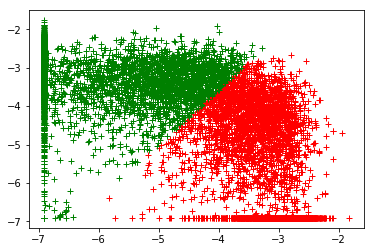

Contigency matrix: 
 [[3438  465]
 [ 322 3657]]

h:  [0.53294375394727811]

c:  [0.53372038411572298]

v:  [0.53333178630219658]

r:  [0.64044168522514522]

m:  [0.53290099479503594]


In [120]:
## Part 4b(iii): Combination of normalization and log transformation on NMF-reduced data

def visualize_nmf_norm_log(data_idf, label, ncomponents, nclusters):
    h = []
    c = []
    v = []
    r = []
    m = []
    ks = []
    
    nmf = NMF(n_components=ncomponents)
    scaler = StandardScaler(copy=False)
    pipeline = make_pipeline(nmf, scaler)
    X_nmf = nmf.fit_transform(data_idf)
    
    log_data = np.log(X_nmf+0.001)

    labels = label
    kmeans = KMeans(n_clusters=nclusters).fit(log_data)
    
#     svd2 = TruncatedSVD(n_components=2)
#     X_svd2 = svd2.fit_transform(X_svd)
    
    x1 = log_data[kmeans.labels_==0][:, 0]
    y1 = log_data[kmeans.labels_==0][:, 1]
    
    plt.plot(x1, y1, 'r+')
    
    x2 = log_data[kmeans.labels_==1][:, 0]
    y2 = log_data[kmeans.labels_==1][:, 1]
    
    plt.plot(x2, y2, 'g+')
    plt.show()


    print("Contigency matrix: \n", metrics.confusion_matrix(labels, kmeans.labels_))
    h, c, v, r, m = save_scores(labels, kmeans.labels_, h, c , v ,r , m)
    
    print("\nh: ", h)
    print("\nc: ", c)
    print("\nv: ", v)
    print("\nr: ", r)
    print("\nm: ", m)


labels = [ int(x / 4) for x in twenty_dataset.target]
visualize_nmf_norm_log(tfidf_data, labels, 2, 2)


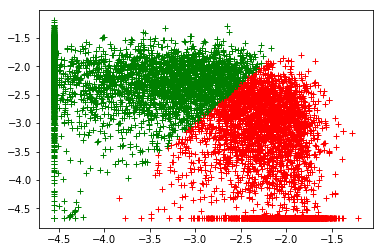

Contigency matrix: 
 [[3406  497]
 [ 288 3691]]

h:  [0.53562830842554687]

c:  [0.53711530816422526]

v:  [0.5363707776813319]

r:  [0.64125435364257122]

m:  [0.53558579502538894]


In [121]:
def visualize_nmf_log_norm(data_idf, label, ncomponents, nclusters):
    h = []
    c = []
    v = []
    r = []
    m = []
    ks = []
    
    nmf = NMF(n_components=ncomponents)
#     scaler = StandardScaler(copy=False)
#     pipeline = make_pipeline(nmf, scaler)
    X_nmf = nmf.fit_transform(data_idf)
    log_data = np.log(X_nmf+0.001)
    scaler = StandardScaler(copy=False, with_mean=False)
    X_transformed = scaler.fit_transform(log_data)
    
    labels = label
    kmeans = KMeans(n_clusters=nclusters).fit(X_transformed)
    
    x1 = X_transformed[kmeans.labels_==0][:, 0]
    y1 = X_transformed[kmeans.labels_==0][:, 1]
    
    plt.plot(x1, y1, 'r+')
    
    x2 = X_transformed[kmeans.labels_==1][:, 0]
    y2 = X_transformed[kmeans.labels_==1][:, 1]
    
    plt.plot(x2, y2, 'g+')
    plt.show()
    
    print("Contigency matrix: \n", metrics.confusion_matrix(labels, kmeans.labels_))
    h, c, v, r, m = save_scores(labels, kmeans.labels_, h, c , v ,r , m)
    
    print("\nh: ", h)
    print("\nc: ", c)
    print("\nv: ", v)
    print("\nr: ", r)
    print("\nm: ", m)
    
visualize_nmf_log_norm(tfidf_data, labels, 2, 2)

## Part 5: Expand Dataset into 20 categories

### Part 5.1: Building TF-IDF Matrix

In [122]:
### Part 5.1: Expand Dataset into 20 categories

tfidf_all = tfidf(twenty_all)

Dimensions of TF-IDF matrix: (18846, 52295)


### Part 5.2: Applying K-means with k=20 to the TF-IDF data

In [123]:
### Part 5.2: Applying K-means with k=20 to the TF-IDF data

kmeans_clustering(20, tfidf_all, twenty_all.target)

Contingency Matrix: 
 [[  0  68   0 174  92   1   0   0  28   0   1   0 229 168   0   0  38   0
    0   0]
 [ 22  73   1   1  93   0   2 379   2  36  16   2 318   0   0   0   0   4
   22   2]
 [ 13  36   5   0  74   0   1 133   0  71   5   0 207   0  11   0   0   2
  417  10]
 [144  27   1   0 145   0   3  36   3 104  13   0 256   0 197   0   0   5
   43   5]
 [542  21   1   0  47   0  13   8   2   7  11   1 231   0  69   0   0   3
    6   1]
 [  4  73   2   0  97   2   2 543   0   4  31   0 170   0   0   0   0   4
   55   1]
 [ 92   5  14   0 164   0  30   2   6   8   4   0 561   0  46   0   0  12
   23   8]
 [  0  25   2   0 527   0  32   0   9   0  11   3 373   0   0   0   0   5
    2   1]
 [  3 108   0   0 562   0   6   0   2   0  24   0 278   0   0   0   0  12
    0   1]
 [  3   2  14   0 149   0   7   1 425   1   7   0 381   0   0   0   0   3
    0   1]
 [  8   3  19   0  42   0   6   0 660   0  10   0 198   0   0   0   0  53
    0   0]
 [  4  49   0   0 148 552  11  20  32   0  

### Part 5.3a (i): Dimensionality Reduction using LSI and NMF

In [128]:
## Part 5.3a (i): Dimensionality Reduction using LSI and NMF
svd = TruncatedSVD(n_components=1000)
X_svd = svd.fit_transform(tfidf_all)
    
ratio = svd.explained_variance_ratio_

with open("ratio_all.pkl","wb") as f:
    s = pickle.dump(ratio,f)

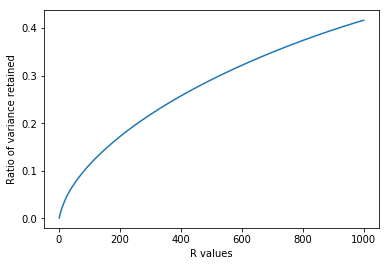

In [129]:
with open("ratio_all.pkl","rb") as f:
    s = pickle.load(f) 
    
total_var = svd.explained_variance_ratio_.sum()

new_ratio = []

for i in range(len(s)):
    new_ratio.append(sum(s[0:i+1]))

r = [i for i in range(1, 1001)]

plt.plot(r, new_ratio)
plt.xlabel('R values')
plt.ylabel('Ratio of variance retained')
plt.show()

### Part 5.3a (ii): Finding the best dimension parameter r

R:  1
[[ 20  81  77  47  13  66  76   0  38  26   6  50  75   1   0   5  75  83
   37  23]
 [ 87  38  29 120   2  17  63  14 118   3  62  98  36  47   2   3  81  54
    6  93]
 [ 40  72  42  95   3  36 118  21  86   6  46 104  38  16   0   0 107  81
   22  52]
 [ 54  69  47  92   1  35  92   2  84   4  44  95  57  18   0   0 105  79
   21  83]
 [ 56  68  47  96   2  28  96   1  95   3  37 106  48  28   0   3  94  66
   15  74]
 [103  36  17  93   1  13  67  12 114   3 100  86  24  69   0   7  81  50
    4 108]
 [ 96  59  18 111   0   9  60   1 120   0  77 101  27  51   0   1  90  57
    7  90]
 [ 63  64  41  84   1  31 108   1  74  13  53 108  45  21   0   1 114  77
   19  72]
 [ 65  61  42 115   0  22  99   0 100   3  34 140  27  14   0   0 120  69
    6  79]
 [ 46  85  36 107   1  28  90   4  86  10  39  89  67  23   0   1  89 105
   24  64]
 [ 60  50  31 107   1  21  98   6  80   6  52 102  56  38   0   1  90 104
   12  84]
 [ 15 114  92  43  15  70  90   1  45  26  15  80 114   3  

[[201   0  54   6  19   0   1   0   0   0   0  38 144 158   0   0  67 110
    0   1]
 [269 249 103   1   7   0  17   0   0   0   0   0   0   1   2   2 100 222
    0   0]
 [113 639  61   0  12   0   3   1   0   0   0   0   0   0   2  11  31 101
   11   0]
 [234 185 146   0  27   0   9   4   0   0   0   0   0   0   3   4  32 147
  191   0]
 [332  58 102   0  23   0  11   1   0   0   0   0   0   0  14   1  25 321
   75   0]
 [254 310 136   0   4   0  28   0   0   0   0   0   0   0   2   1  96 153
    0   4]
 [198  47 151   5  14   0   3  12   0   0   0   0   0   0  31   6   5 454
   49   0]
 [325   2 342   4  15   0  12   0   0   0   0   0   0   0  32   0  25 233
    0   0]
 [234   0 466   0   9   0  19   1   0   0   0   0   0   0   7   1 100 159
    0   0]
 [139   0 139   5   1   0   4 388   0   0   0   0   0   0   7   1   2 308
    0   0]
 [ 65   0  40   0   5   0   4 765   0   0   0   0   0   0   6   0   3 111
    0   0]
 [150  12 127  36   0   0   9   0   0   1   0   0   0   0   8  33

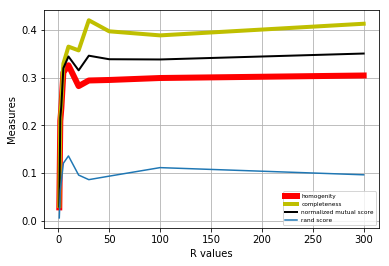


h:  [0.028107019773196011, 0.20951914133391025, 0.23558058716226349, 0.31101910700863244, 0.32596093769562934, 0.28224939991399189, 0.29405050619360712, 0.29512333514028388, 0.29924506498024189, 0.30449722455296929]

c:  [0.03091595331920349, 0.22306941421762116, 0.24549010650209704, 0.32918596083978752, 0.36501435814036226, 0.35711827796697615, 0.42031228436815843, 0.39711440184060065, 0.38858658054117684, 0.41297838819996124]

v:  [0.029444647252510375, 0.21608205545403908, 0.24043328431326175, 0.31984477700014213, 0.34438401247862177, 0.31530032918949835, 0.34602317368925778, 0.3386054253978738, 0.33811359887736797, 0.3505367172683273]

r:  [0.0060211751706676581, 0.06424905302647238, 0.081917412999576403, 0.12059337914262762, 0.13591322714360388, 0.09582046706647783, 0.086230069501824477, 0.09355392916604989, 0.11142773816226147, 0.096385719561590269]

m:  [0.024936303456201764, 0.20695783280876393, 0.23310933214839799, 0.30879086583944593, 0.323769613002518, 0.27990415487132947, 

In [130]:
### Part 5.3a (ii): Finding the best dimension parameter r

#SVD r=10

labels = twenty_all.target
 calc_scores_for_svd(tfidf_all, r, labels, 20)

R:  1
[[ 60  25  17  85   0  39  88   1  75  71  11  23  70   0  92  51   6  22
   57   6]
 [104   5  85  41   2 115  71  47  20  82   2  95  29  14  54 130  57   3
   14   3]
 [114  17  36  63   0  87 124  16  39 110   3  57  36  21  87 100  40   4
   31   0]
 [109  15  55  60   0  86  97  18  33 107   1  79  64   2  86  98  40   2
   30   0]
 [109   7  55  66   0  98  95  28  40 106   2  72  48   1  74 101  33   2
   23   3]
 [ 95   4  94  34   0 116  70  68  15  77   1 112  23  12  51 102  98   3
    6   7]
 [109   3  96  46   0 126  61  48  10  93   0  83  27   1  68 116  76   0
   11   1]
 [117  15  63  58   0  78 106  21  36 113   1  70  51   1  84  90  49  10
   26   1]
 [148   5  54  53   0 108  96  14  39 131   0  79  29   0  71 121  33   3
   12   0]
 [ 99  21  36  80   0  87  97  23  38  90   1  69  54   4 116 111  39   8
   20   1]
 [110  10  56  56   0  88  93  38  30 101   1  83  47   6 105 108  48   6
   12   1]
 [ 87  40  13 123   2  43  96   3  73  80  15  35 113   1 1

[[  0  14 138   1   1  38 113   0   0   2   0   0   0   1 227  66  69   0
  129   0]
 [323   7   1  16   0   0  16   0   0   1   2   0   0   2 405  82 118   0
    0   0]
 [652  15   0   2   0   0   8   0   0   0   2   0  11  12 184  34  65   0
    0   0]
 [206  28   0   9   0   0  10   0   4   0   3   0 201   4 312  29 176   0
    0   0]
 [ 87  23   0  10   0   0  17   0   1   0  14   0  82   1 590  24 114   0
    0   0]
 [390   4   0  27   5   0   3   0   0   0   2   0   0   2 316  87 152   0
    0   0]
 [ 51  14   0   4   0   0  12   0  14   5  32   0  59   7 615   5 157   0
    0   0]
 [  3  20   0  11   0   0 229   0   1   3  31   0   0   0 342  27 323   0
    0   0]
 [  0   9   0  17   0   0 102   0   2   0   6   0   0   1 287 105 467   0
    0   0]
 [  0   1   0   3   0   0  29   0 377   4   7   0   0   1 425   2 145   0
    0   0]
 [  0   5   0   3   0   0   5   0 773   0   6   0   0   0 170   2  35   0
    0   0]
 [ 15   0   0   6 477   0  67   1   0  16   8   0   0  33 163  50

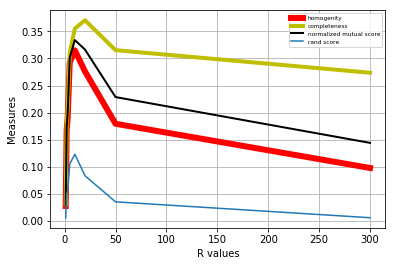


h:  [0.027853162377013976, 0.16882243449500522, 0.19111787614765977, 0.29274997620352683, 0.3149473319994191, 0.27588442670080543, 0.17942356833031942, 0.097885513830824361]

c:  [0.030975659098749334, 0.17962146740078624, 0.2078624127613814, 0.31012057815998179, 0.35508605805453686, 0.370388442162289, 0.31520341067060154, 0.2735190331817568]

v:  [0.029331543313950131, 0.17405460821199817, 0.19913877433148153, 0.30118502626955956, 0.33381442857784027, 0.31622680742364301, 0.22867705601760596, 0.14417460055813272]

r:  [0.0057825414233596993, 0.050696060258931044, 0.056577107014621417, 0.10515658047825127, 0.12318172856292847, 0.083526929197327515, 0.035448645286705514, 0.0061614448866317457]

m:  [0.024680688297136693, 0.1661125540674267, 0.18849267824615845, 0.29046111307105998, 0.31272075720611181, 0.27351282948276689, 0.17672613002141202, 0.094810501472847683]


In [132]:
#NMF best r=10

labels = twenty_all.target
r = [1, 2, 3, 5, 10, 20, 50, 300]
calc_scores_for_nmf(tfidf_all, r, labels, 20)

### Part 5.4a: Visualizing the performance of case with best clustering results.

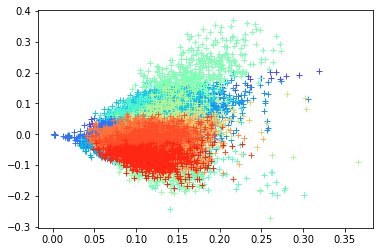

In [145]:
### Part 4a: Visualizing the performance of case with best clustering results. r=10 for svd
# SVD
import matplotlib.cm as cm

def visualize_svd(data_idf, nclusters, ncomponents):
    svd = TruncatedSVD(n_components=ncomponents)
    X_svd = svd.fit_transform(data_idf)

    kmeans = KMeans(n_clusters=nclusters).fit(X_svd)
    
    svd2 = TruncatedSVD(n_components=2)
    X_svd2 = svd2.fit_transform(X_svd)
    
    colors = iter(cm.rainbow(np.linspace(0, 1, nclusters+1)))
    
    for i in range(0, nclusters):
        plt.plot(X_svd2[kmeans.labels_==i][:, 0], X_svd2[kmeans.labels_==i][:, 1], '+', color=next(colors))

    plt.show()
    
visualize_svd(tfidf_all, 20, 10)

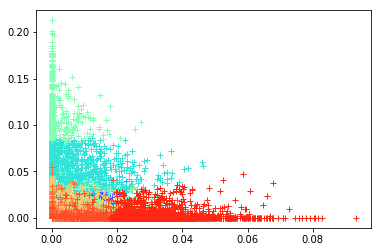

In [146]:
#NMF

def visualize_nmf(data_idf, nclusters, ncomponents):
    nmf = NMF(n_components=ncomponents)
    X_nmf = nmf.fit_transform(data_idf)

    kmeans = KMeans(n_clusters=nclusters).fit(X_nmf)
    
    
    nmf2 = TruncatedSVD(n_components=2)
    X_nmf2 = nmf2.fit_transform(X_nmf)
    
    colors = iter(cm.rainbow(np.linspace(0, 1, nclusters+1)))
    for i in range(nclusters):
        plt.plot(X_nmf[kmeans.labels_==i][:, 0], X_nmf[kmeans.labels_==i][:, 1], '+', color=next(colors))


    plt.show()
    
visualize_nmf(tfidf_all, 20, 10)

### Part 5.4b(i): Visualizing the transformed data after normalizing 

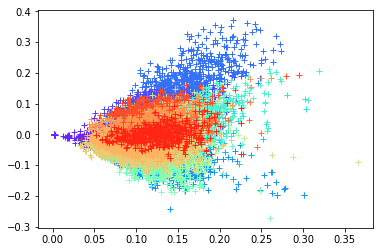

Contigency matrix: 
 [[  0  59 282  58   0   1 121   1  38   0   0  68   7 116   0  38  10   0
    0   0]
 [  0 150   1   0  69  16 164   0   4  19   0  38   9   1 420  82   0   0
    0   0]
 [  0  64   0   0 363   3  73   0   2  39   2   4   9   0 369  57   0   0
    0   0]
 [  4 104   0   0  43   4  88   0   1 305 105  13  29   0 171 113   0   0
    0   2]
 [  2 173   0   0   9   9 239   0   2 258  22  13  34   0 119  83   0   0
    0   0]
 [  0 119   0   0  95  23 108   0   0   1   0  40   4   0 491 101   0   0
    0   6]
 [ 22 242   1   0  16   5 312   0   3 124  16   6  45   1  55 125   0   2
    0   0]
 [  8 292   0   0   0   8 227   0  79   6   0   8  40   4   8 310   0   0
    0   0]
 [ 22 260   5   0   0  16 161   0  29   2   0  52  15  30   1 403   0   0
    0   0]
 [416  95   0   0   0   2 205   0  10   0   0   1   8   3   1 126   0 127
    0   0]
 [471  42   0   0   0   3  64   0   3   0   0   1  10   1   0  36   0 368
    0   0]
 [  0  49   0   0   6   5  55 222  43   0   

In [148]:
### Part 5.4b(i): Visualizing the transformed data after normalizing 

#SVD

def visualize_svd_normalized(data_idf, label, ncomponents, nclusters):
    h = []
    c = []
    v = []
    r = []
    m = []
    ks = []
    
    svd = TruncatedSVD(n_components=ncomponents)
    scaler = StandardScaler(copy=False)
    pipeline = make_pipeline(svd, scaler)
    X_svd = svd.fit_transform(data_idf)

    labels= label  
    kmeans = KMeans(n_clusters=nclusters).fit(X_svd)
    
    svd2 = TruncatedSVD(n_components=2)
    X_svd2 = svd2.fit_transform(X_svd)
    
    colors = iter(cm.rainbow(np.linspace(0, 1, nclusters+1)))
    
    for i in range(nclusters):
        plt.plot(X_svd2[kmeans.labels_==i][:, 0], X_svd2[kmeans.labels_==i][:, 1], '+', color=next(colors))

    plt.show()
    
    print("Contigency matrix: \n", metrics.confusion_matrix(labels, kmeans.labels_))
    h, c, v, r, m = save_scores(labels, kmeans.labels_, h, c , v ,r , m)
    
    print("\nh: ", h)
    print("\nc: ", c)
    print("\nv: ", v)
    print("\nr: ", r)
    print("\nm: ", m)

labels = twenty_all.target
visualize_svd_normalized(tfidf_all, labels, 10, 20)

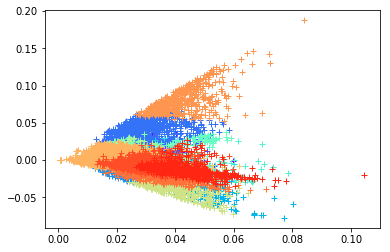

Contigency matrix: 
 [[ 14   0 105   1 230   1   0   2   8   0 108   0   5  49   1  88   0   0
  115  72]
 [ 19   3  98   1   1   0   0  13   0   0 127 102 419   0   8 159   0   1
    4  18]
 [ 12  24  70   1   0   0   2  12   0   0  51 340 382   0   2  77   0   0
    2  10]
 [ 16 199 137   6   0   0  91  16   0   0  95  38 228   0   2 126   0   4
    1  23]
 [ 17 130  97   7   0   0  15  10   0   0 236   6 186   0   4 237   0   2
    1  15]
 [ 12   1 124   1   0   0   0  18   0   0  73 133 472   0  15 108   0  12
    0  19]
 [ 18  89 129  19   1   0  12  11   0   0 343   8  68   0   1 246   3   1
    3  23]
 [  5   2 333   7   0   0   0  16   0   0 244   0   8   0   4 220   0   0
   82  69]
 [ 10   2 373  27   8   0   0  20   0   0 137   0  16   0   2 207   0   0
   35 159]
 [ 25   0 104 459   0   0   0   3   0   0 152   0   2   0   1  89 127   0
    2  30]
 [  9   0  24 470   1   0   0   3   0   0  42   0   0   0   0  35 407   0
    1   7]
 [  8   0  71   2   0 243   0  15   7   0  3

In [158]:
#NMF

def visualize_nmf_normalized(data_idf, label, ncomponents, nclusters):
    h = []
    c = []
    v = []
    r = []
    m = []
    ks = []
    
    nmf = NMF(n_components=ncomponents)
    scaler = StandardScaler(copy=False)
    pipeline = make_pipeline(nmf, scaler)
    X_svd = nmf.fit_transform(data_idf)

    labels = label
    kmeans = KMeans(n_clusters=nclusters).fit(X_svd)
    
    svd2 = TruncatedSVD(n_components=2)
    X_svd2 = svd2.fit_transform(X_svd)
    
    colors = iter(cm.rainbow(np.linspace(0, 1, nclusters+1)))
    
    for i in range(nclusters):
        plt.plot(X_svd2[kmeans.labels_==i][:, 0], X_svd2[kmeans.labels_==i][:, 1], '+', color=next(colors))
    plt.show()
    
    print("Contigency matrix: \n", metrics.confusion_matrix(labels, kmeans.labels_))
    h, c, v, r, m = save_scores(labels, kmeans.labels_, h, c , v ,r , m)
    
    print("\nh: ", h)
    print("\nc: ", c)
    print("\nv: ", v)
    print("\nr: ", r)
    print("\nm: ", m)

labels = twenty_all.target
visualize_nmf_normalized(tfidf_all, labels, 10, 20)

### Part 5.4b(ii): Visualizing the transformed data after a non-linear (logarithm) transformation (NMF)

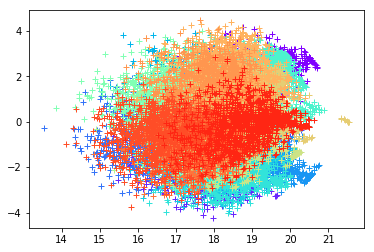

Contigency matrix: 
 [[  0 188   1  84  22   4 251  34   7   4   0   2   1 166   2   0   1  19
   13   0]
 [208   8   7  44   0  73   1   1 239  24  86   5   1   0 151  13  36  20
   53   3]
 [276   6   6  11   0  47   0   0 223  11  57   4   2   0 199  42  59   9
   31   2]
 [ 44   0   4   9   0  37   1   1  73  17 147   3   5   0  44 273 281  13
   27   3]
 [ 21   0   8  24   8  25   0   0 109  13 242   1   6   0  21 275 163  22
   19   6]
 [238   3   9  21   0  87   0   0 159  34  14   9  13   1 338   0  21   5
   35   1]
 [ 13   1  39   3  10  47   0   2 138  20 157   6   4   2  36 262 112  64
   19  40]
 [  7   1  38  22  22  12   7  65  67  30  33   7   2   1  77   7  29 409
  147   7]
 [  1   2 146  28   8  17  20  69  34  28  17   9   0   0  89  15  37 302
  167   7]
 [  0  11 260  39   3  22   0   0  27   6  13   0   1   1   7   0   1  86
   44 473]
 [  1   8 230   9   1  10   0   0   5   8   3   0   0   1   5   0   0   8
   10 700]
 [  7   3   2  28   6  13   0   6  12  15  2

In [149]:
## Part 5.4b(ii): Visualizing the transformed data after a non-linear (logarithm) transformation (NMF)

def visualize_nmf_log(data_idf, label, ncomponents, nclusters):
    h = []
    c = []
    v = []
    r = []
    m = []
    ks = []
    
    nmf = NMF(n_components=ncomponents)
    #scaler = StandardScaler(copy=False)
    #pipeline = make_pipeline(nmf, scaler)
    X_nmf = nmf.fit_transform(data_idf)
    
    X_nmf = np.array(X_nmf)
    log_data = np.log(X_nmf+0.001)
    
    kmeans = KMeans(n_clusters=nclusters).fit(log_data)
    
    svd2 = TruncatedSVD(n_components=2)
    X_svd2 = svd2.fit_transform(log_data)
    
    colors = iter(cm.rainbow(np.linspace(0, 1, nclusters+1)))
    
    for i in range(nclusters):
        plt.plot(X_svd2[kmeans.labels_==i][:, 0], X_svd2[kmeans.labels_==i][:, 1], '+', color=next(colors))
    plt.show()
    labels= label
    
    print("Contigency matrix: \n", metrics.confusion_matrix(labels, kmeans.labels_))
    h, c, v, r, m = save_scores(labels, kmeans.labels_, h, c , v ,r , m)
    
    print("\nh: ", h)
    print("\nc: ", c)
    print("\nv: ", v)
    print("\nr: ", r)
    print("\nm: ", m)

labels = twenty_all.target
visualize_nmf_log(tfidf_all, labels, 10, 20)

### Part 5.4b(iii): Combination of normalization and log transformation on NMF-reduced data

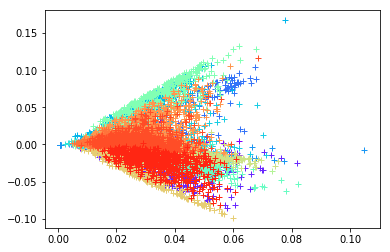

Contigency matrix: 
 [[  3 232   7  65  25   3  16   0   0   1   0  19   1  34 133   1   1   0
   17 241]
 [ 24   6 270  51   9   6  47 195 155   2   1   0 104   1   0  40   9  24
   27   2]
 [ 12   5 243  27  17   2  28 258 214   2   0   0  54   0   0  61   4  47
   11   0]
 [ 16   0  78  18  15   2  26  41  47   6   3   0 127   1   0 292   5 296
    8   1]
 [ 13   0  99  30  14   9  19  19  18   1   0   8 196   0   0 175   9 328
   25   0]
 [ 36   1 210  36  10   3  33 220 366  10   0   0  27   0   1  20  11   0
    4   0]
 [ 13   1 115  21  81  59  15  11  18   3   7  13 130   1   2 104  44 288
   49   0]
 [ 22   1  50  27 136  15 108   5  34   7   0  24  21  56   1  22  43   7
  406   5]
 [ 28   1  23  38 147  15 134   0  55   1   0  11   9  62   0  29 149  15
  261  18]
 [  5   3  20  42  13 430  29   0   4   0  86   3  15   0   0   0 239   0
  105   0]
 [  3   2   2   7   3 467   9   1   3   0 311   1   1   0   1   0 176   0
   12   0]
 [ 18   4  15  44   9   2  44   9  23 721   

In [151]:
## Part 5.4b(iii): Combination of normalization and log transformation on NMF-reduced data

def visualize_nmf_norm_log(data_idf, label, ncomponents, nclusters):
    h = []
    c = []
    v = []
    r = []
    m = []
    ks = []
    
    nmf = NMF(n_components=ncomponents)
    scaler = StandardScaler(copy=False)
    pipeline = make_pipeline(nmf, scaler)
    X_nmf = nmf.fit_transform(data_idf)
    
    log_data = np.log(X_nmf+0.001)

    labels = label
    kmeans = KMeans(n_clusters=nclusters).fit(log_data)
    
    svd2 = TruncatedSVD(n_components=2)
    X_svd2 = svd2.fit_transform(X_nmf)
    
    colors = iter(cm.rainbow(np.linspace(0, 1, nclusters+1)))
    
    for i in range(nclusters):
        plt.plot(X_svd2[kmeans.labels_==i][:, 0], X_svd2[kmeans.labels_==i][:, 1], '+', color=next(colors))
    plt.show()


    print("Contigency matrix: \n", metrics.confusion_matrix(labels, kmeans.labels_))
    h, c, v, r, m = save_scores(labels, kmeans.labels_, h, c , v ,r , m)
    
    print("\nh: ", h)
    print("\nc: ", c)
    print("\nv: ", v)
    print("\nr: ", r)
    print("\nm: ", m)


labels = twenty_all.target
visualize_nmf_norm_log(tfidf_all, labels, 10, 20)


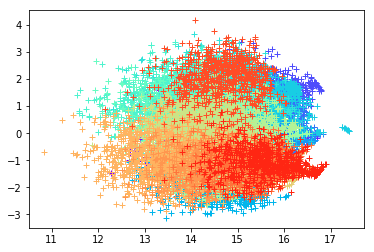

Contigency matrix: 
 [[  1   1   0   9   0 273   7   0   0  10  22  80   5   3 226  85  24  34
    1  18]
 [  6   8 164 195   3   0 152  23  52 128 127   3  26  23   0  37   3   1
   22   0]
 [  5   3 247 214   0   1 187  61  26  94  60   3  16  17   0   6   0   0
   45   0]
 [  6   1  33  56   2   0  52 270 128  61  18   9  17  20   0  10   3   1
  295   0]
 [  2  11  17  73   3   0  24 369 169  42  39   5  10  33   0  16   9   8
  133   0]
 [ 19   2 197 144   6   1 327   5  14 137  58   3  37   5   1  12   1   2
   17   0]
 [  5  52   8 106  15   1  55 329  92  44  60  18  16  65   2   1  12  11
   83   0]
 [  9  24   4  51   9   6  78  21  22   6  67 212  28 335   1  32  18  33
   21  13]
 [  3  41   0  24  28   7 119  24   6  11  56 175  34 305  12  42  38  12
   31  28]
 [  1 435   0  18 185   6  16   0   4   6  34  22   9  90   0  28 135   4
    1   0]
 [  0 439   1   3 422   1   6   0   2   1   4   1   9  18   0  11  80   1
    0   0]
 [765   1   4  11   2   3  20   0  51  25  2

In [153]:
def visualize_nmf_log_norm(data_idf, label, ncomponents, nclusters):
    h = []
    c = []
    v = []
    r = []
    m = []
    ks = []
    
    nmf = NMF(n_components=ncomponents)
#     scaler = StandardScaler(copy=False)
#     pipeline = make_pipeline(nmf, scaler)
    X_nmf = nmf.fit_transform(data_idf)
    log_data = np.log(X_nmf+0.001)
    scaler = StandardScaler(copy=False, with_mean=False)
    X_transformed = scaler.fit_transform(log_data)
    
    labels = label
    kmeans = KMeans(n_clusters=nclusters).fit(X_transformed)
    
    svd2 = TruncatedSVD(n_components=2)
    X_svd2 = svd2.fit_transform(X_transformed)
    
    colors = iter(cm.rainbow(np.linspace(0, 1, nclusters+1)))
    
    for i in range(nclusters):
        plt.plot(X_svd2[kmeans.labels_==i][:, 0], X_svd2[kmeans.labels_==i][:, 1], '+', color=next(colors))
    plt.show()
    
    print("Contigency matrix: \n", metrics.confusion_matrix(labels, kmeans.labels_))
    h, c, v, r, m = save_scores(labels, kmeans.labels_, h, c , v ,r , m)
    
    print("\nh: ", h)
    print("\nc: ", c)
    print("\nv: ", v)
    print("\nr: ", r)
    print("\nm: ", m)
    
visualize_nmf_log_norm(tfidf_all, labels, 10, 20)